# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Prediction interval via SKLearn Gradient Boosting with Quantile Loss Function



# Some theoretical recalls


- A **CONFIDENCE** interval quantifies the uncertainty on an estimated population variable, such as the mean or 
standard deviation. It can be used to quantify the uncertainty of the estimated skill of a model.
- A **PREDICTION** interval quantifies the uncertainty on a single observation estimated from the population. It
can be used to quantify the uncertainty of a single forecast. 
- **Median**: The middle value in the sample, also called the 50th percentile or the 2nd quartile. 
- **1st Quartile**: The 25th percentile. 
- **3rd Quartile**: The 75th percentile. 
- **Quantile:** These are points in your data below which a certain proportion of your data fall. Consider a normal distribution with a mean of 0. The 0.5 quantile, or 50th percentile, is 0. Half the data lie below 0. That’s the peak of the hump in the curve. The 0.95 quantile, or 95th percentile, is about 1.64.  



# Import modules

In [1]:
import numpy as np
import pandas as pd
from math import e
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_pinball_loss
from statistics import stdev
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, ensemble
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
rcParams['figure.figsize'] = 25, 8
rcParams['font.size'] = 20
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Dataset


- Let’s look at the well-known **Boston housing** dataset and try to create prediction intervals
- We’ll use 400 samples for training, leaving 106 samples for test. 
- The size of the forest should be relatively large, so let’s use 1000 trees.



In [2]:
boston = load_boston()
X = boston["data"]
Y = boston["target"]
size = len(boston["data"])
print(len(X), len(Y))

506 506


In [3]:
trainsize = 400
idx = list(range(size))
#shuffle the data
np.random.shuffle(idx)

In [4]:
X_train = X[idx[:trainsize]]
y_train = Y[idx[:trainsize]]
X_test = X[idx[trainsize:]]
y_test = Y[idx[trainsize:]]

# Modelling + no tuning


- PIs with the Gradient Boosting Regressor. GB builds an additive model in a forward stage-wise 
fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree
is fit on the negative gradient of the given loss function. From sklearn userguide we know these are the options:
loss{‘ls’, ‘lad’, ‘huber’, ‘quantile’}.

    - For the **lower prediction**, use the GradientBoostingRegressor with loss='quantile' and alpha=lower_quantile 
      (for example, 0.1 for the 10th percentile)
    - For the **upper prediction**, use the GradientBoostingRegressor with loss='quantile' and alpha=upper_quantile 
      (for example, 0.9 for the 90th percentile)
    - For the **mid prediction**, use GradientBoostingRegressor(loss="quantile", alpha=0.5) which predicts the median,
      or the default loss="ls" (for least squares) which predicts the mean which was we are going to use.
      
- **IMPORTANT**: when we change the loss to quantile and choose alpha (the quantile), we’re able to get predictions 
corresponding to percentiles. If we use lower and upper quantiles, we can produce an estimated range which is exactly 
what we want. 
- **CL** stands for confidence level which is neither CI or PI.
- The **mid_model** will use the default ls which predict the mean.
- The **medina_model** was created to investigate the **strange phenomena** where the median > upper quantile!



In [5]:
# Set lower and upper quantile. 
CL = 0.9
LOWER_ALPHA = (1 - CL)/2
UPPER_ALPHA = CL + LOWER_ALPHA
print(LOWER_ALPHA*100, UPPER_ALPHA*100)

N_ESTIMATORS = 300
# The depeer you got the more likley you are to overfit
MAX_DEPTH = 2

# 4 models: 3 quantiles and one as you'd do normally
mid_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, 
                                        max_depth=MAX_DEPTH)

median_model = GradientBoostingRegressor(loss="quantile", alpha = 0.5, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, 
                                        max_depth=MAX_DEPTH)

4.999999999999999 95.0


In [6]:
lower_model.fit(X_train, y_train);
mid_model.fit(X_train, y_train);
median_model.fit(X_train, y_train);
upper_model.fit(X_train, y_train);


- Mean computing MSE, RMSE, MAE and R2 you have to use the ls as a loss function. 
- If you compute the median for the mid_model and then try to compute the MSE, this will force you to compare median with mean which are the same thing only if the distribution is normal.
- From the results shown below we see the test error is a bit too high? Are we overfitting? Plotting the learnig curve can help us.



In [35]:
preds = mid_model.predict(X_train)

r2_s = r2_score(y_train, preds)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, preds)

print("MidModel [MSE]_train80%: ", mse)
print("MidModel [RMSE]_train80%: ", rmse)
print("MidModel [MAE]_train80%: ", mae)
print("MidModel [R2]_train80%: ", r2_s)

MidModel [MSE]_train80%:  1.6104954957353035
MidModel [RMSE]_train80%:  1.2690529916970779
MidModel [MAE]_train80%:  0.9923566076360438
MidModel [R2]_train80%:  0.9807626020242183


In [36]:
preds = mid_model.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  8.796025441418815
MidModel [RMSE]_test20%:  2.965809407466841
MidModel [MAE]_test20%:  2.1672182480881266
MidModel [R2]_test20%:  0.8984286077013045



- It would be interesting to see the learning curve which will give us a feeling of the trend.
- You will see that mid is OK, but median, lower and upper are not converging well.
- It seems that maybe tuning could offer some solution.



In [9]:
# List of models we'd like to evaluate
models = []
models.append(('mid', mid_model))
models.append(('median', median_model))
models.append(('lower', lower_model))
models.append(('upper', upper_model))

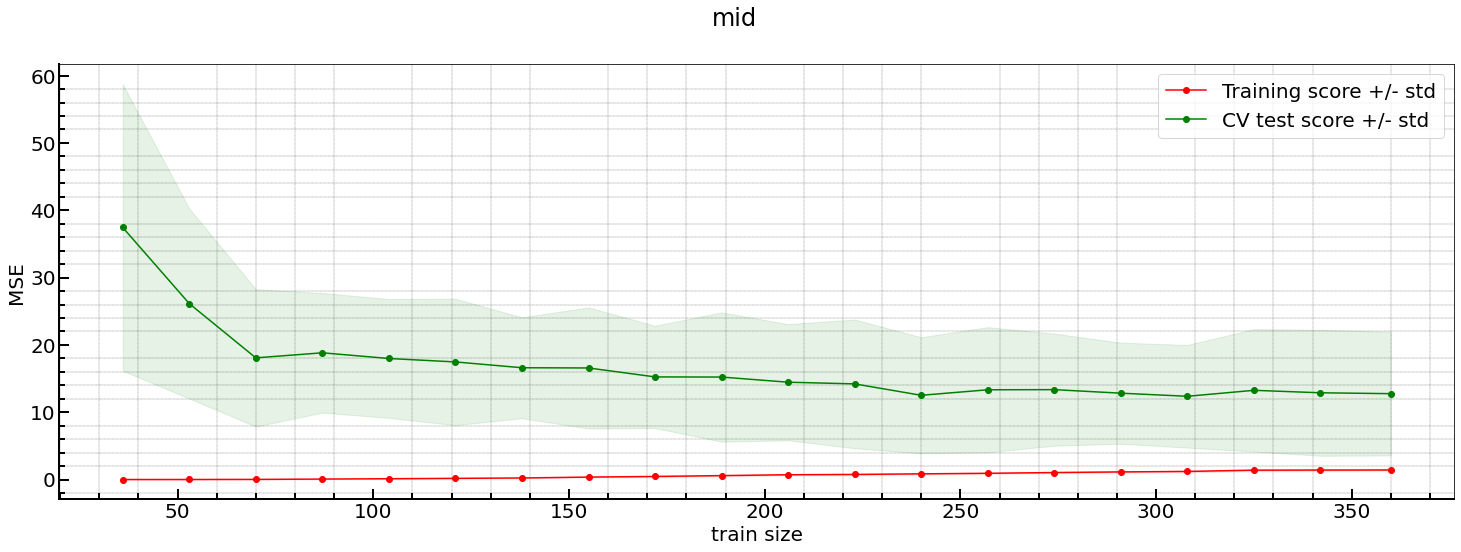

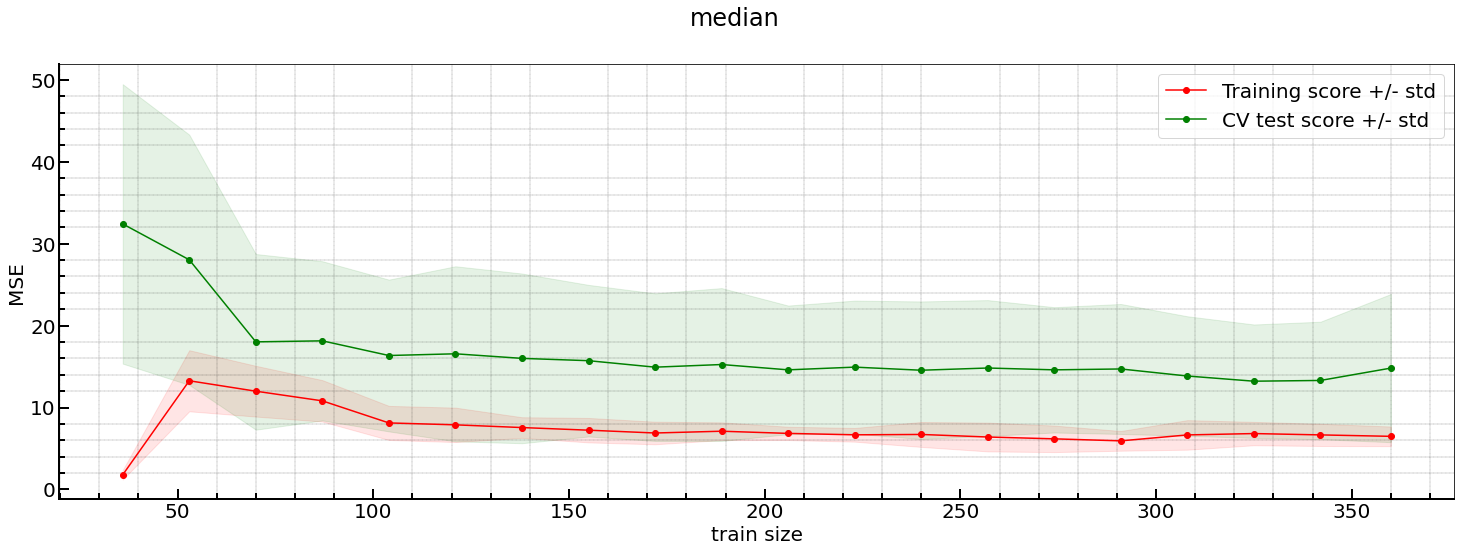

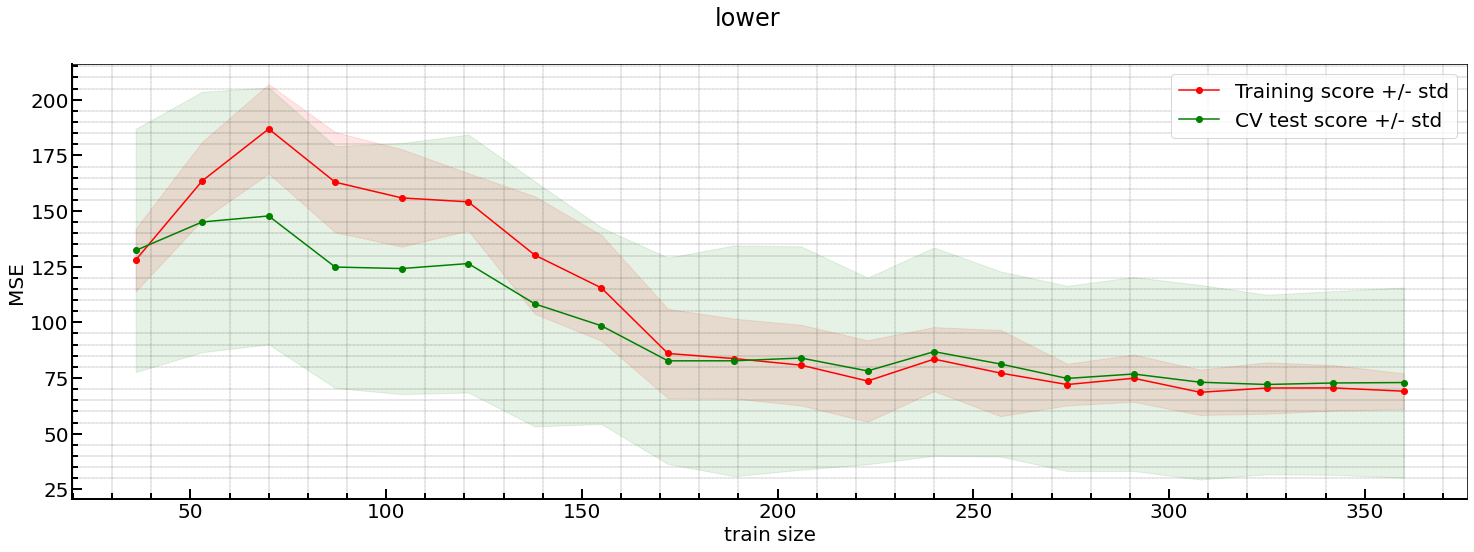

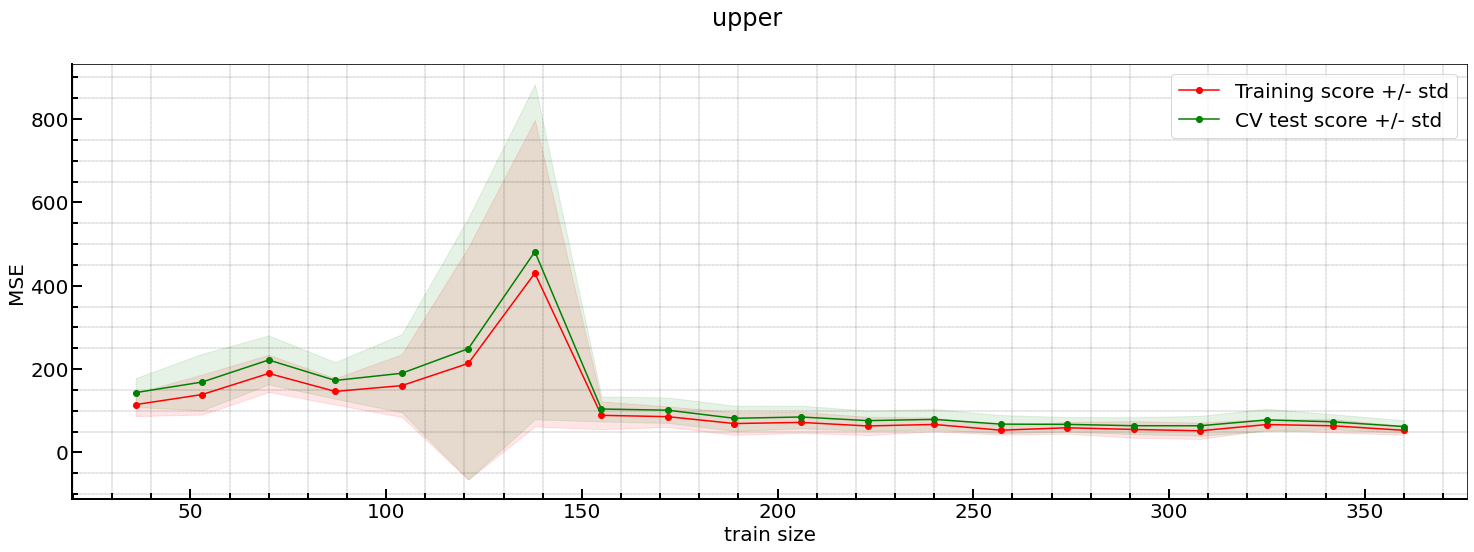

In [10]:
# I've noticed that 10-fold split is a popular setting for this small dataset
kfold = KFold(n_splits=10, shuffle=True, random_state=7)


for name, model in models:
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train,
                                                            y_train,
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(
                                                                0.1, 1, 20),
                                                            scoring="neg_mean_squared_error")

    train_scores_mean = -1*np.mean(train_scores, axis=1)
    train_scores_std = -1*np.std(train_scores, axis=1)
    test_scores_mean = -1*np.mean(test_scores, axis=1)
    test_scores_std = -1*np.std(test_scores, axis=1)

    # Plot learning curve
    fig = plt.figure()
    fig.suptitle(name)
    ax = fig.add_subplot(111)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score +/- std")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV test score +/- std")

    ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which='major', direction='in', length=10, width=2)
    ax.tick_params(which='minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.minorticks_on()

    ax.set_xlabel("train size")
    ax.set_ylabel("MSE")

    plt.legend(loc="best")
    plt.grid()

# Tuning gradient boosting


- For the mid model we'll use the **MSE** 
- But for the quantile we'll have to use a different one in order to pbtain a correct calibration.
- The **pinball loss** function is a metric used to assess the accuracy of a quantile forecast. 
    


## Tuning for the mean -> MSE

In [11]:
def report(results, n_top=1):
    """
    This is just a helper function to report the first n_top
    CV results.
    """
    for i in range(1, n_top + 1):
        print(i)
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.9f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [100, 150]
}

model = ensemble.GradientBoostingRegressor()
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
rsearch = RandomizedSearchCV(estimator=model,
                             param_distributions=param_grid,
                             n_iter=300,
                             random_state=7,
                             scoring='neg_mean_squared_error',
                             cv=kfold,
                             verbose=True,
                             n_jobs=-1)

rsearch.fit(X_train, y_train)
print("Best hyperparamters: ", rsearch.best_estimator_)
print("CV MSE [best hence not mean]: ", rsearch.best_score_)
report(rsearch.cv_results_)

## Tuning for the lower, median and upper (quantile) -> pinball loss

In [ ]:
for quantile in [LOWER_ALPHA, 0.5, UPPER_ALPHA]:

    pinball_lower = make_scorer(
        mean_pinball_loss,
        alpha=quantile,
        greater_is_better=False)

    model = ensemble.GradientBoostingRegressor(loss="quantile")
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    rsearch = RandomizedSearchCV(estimator=model,
                                 param_distributions=param_grid,
                                 n_iter=300,
                                 random_state=7,
                                 scoring=pinball_lower,
                                 cv=kfold,
                                 verbose=True,
                                 n_jobs=-1)

    rsearch.fit(X_train, y_train)
    print("-------------------------")
    print("Quantile=" + str(quantile))
    print("Best hyperparamters: ", rsearch.best_estimator_)
    print("CV pinball [best hence not mean]: ", rsearch.best_score_)
    report(rsearch.cv_results_)

## Plotting learning curves for tuned model


- Let us see how the learning curves look
- Each models will get its own hyperparameters.



neg_mean_squared_error
make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.5)
make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.04999999999999999)
make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.95)


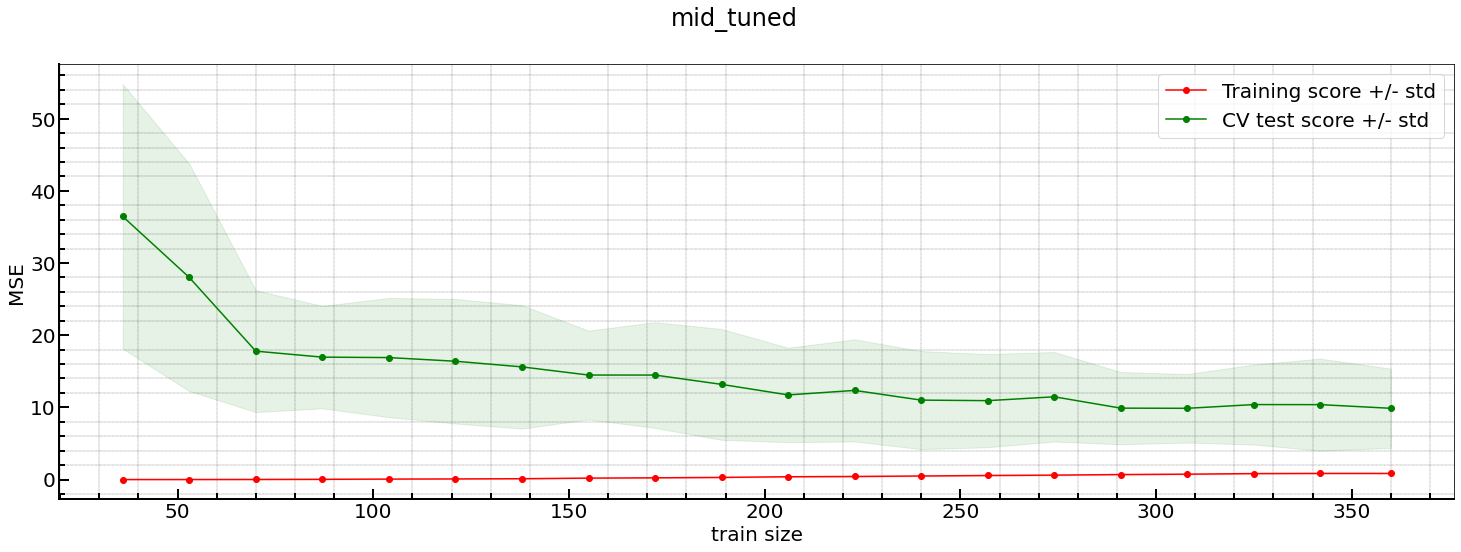

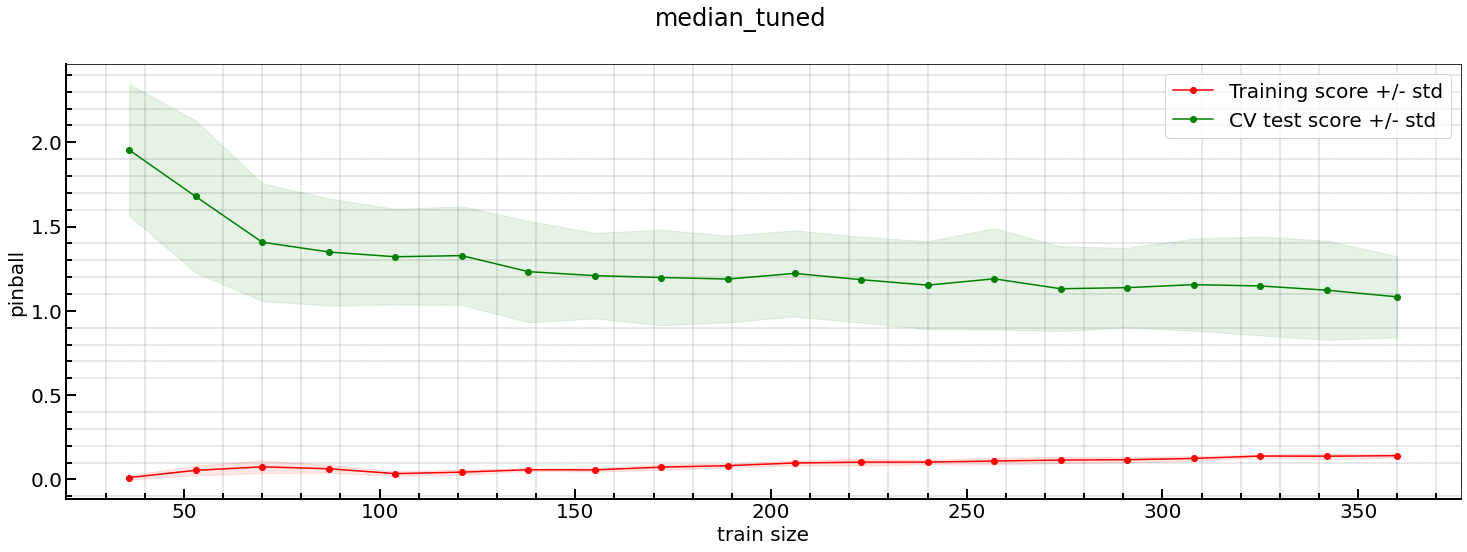

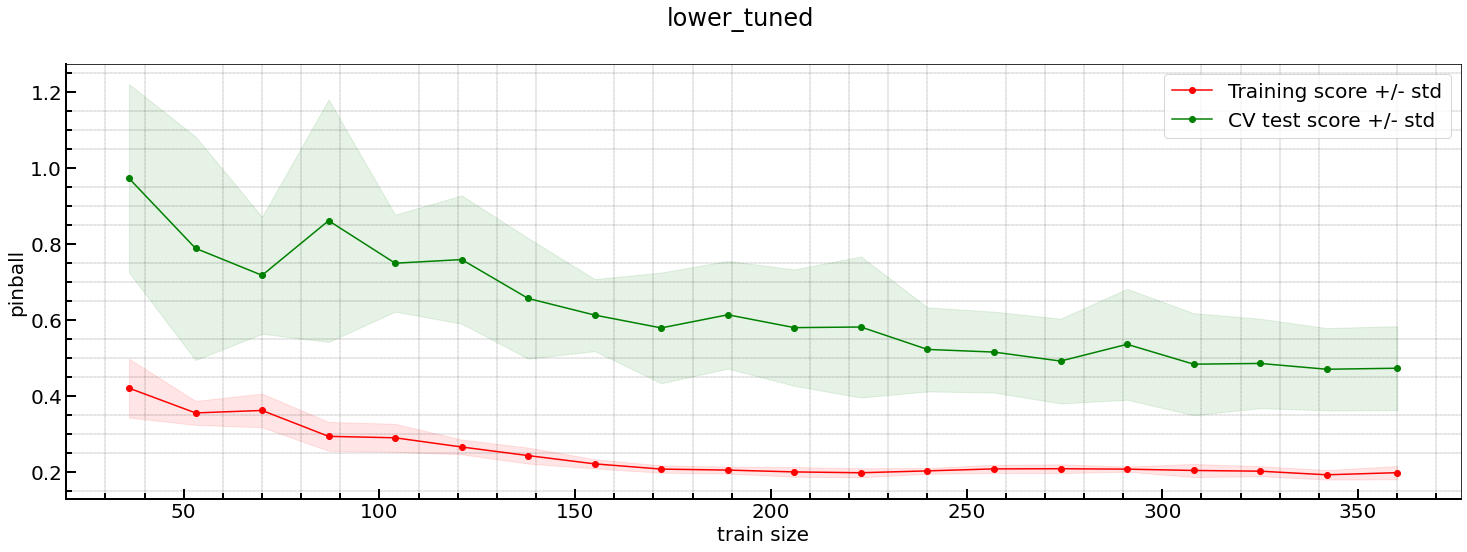

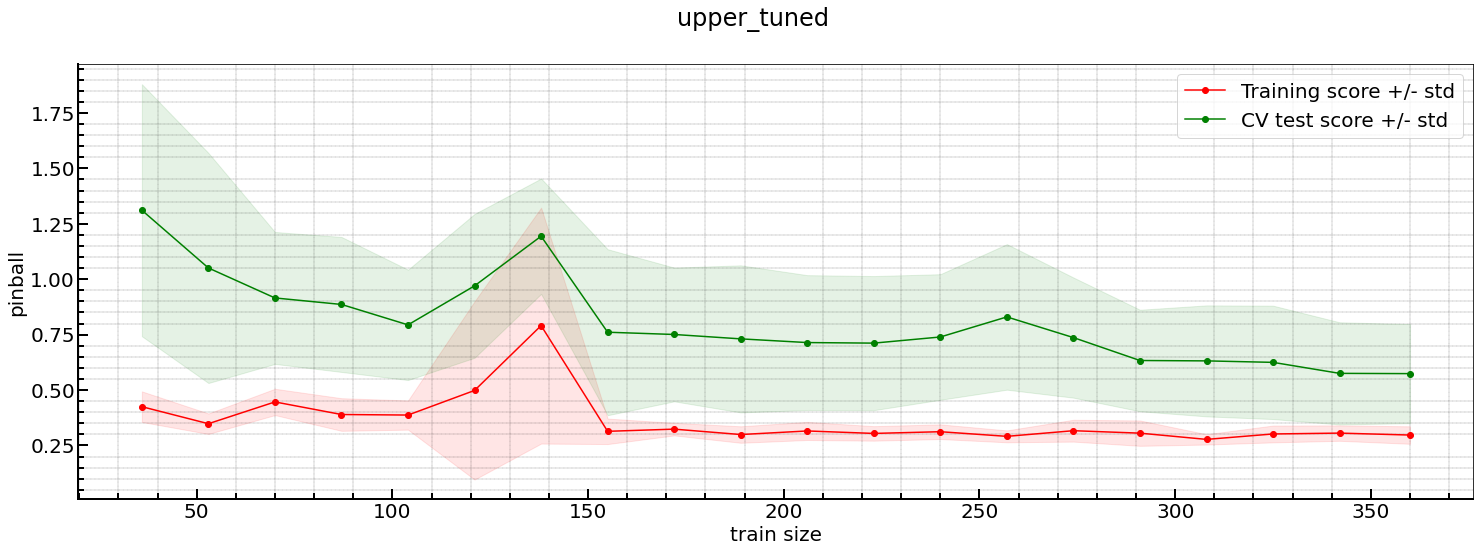

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

# As usual
mid_model_tuned = GradientBoostingRegressor(
    learning_rate=0.04, max_depth=3, n_estimators=400)

# Quantiles
lower_model_tuned = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA,
                                              learning_rate=0.06, max_depth=6, n_estimators=500)
median_model_tuned = GradientBoostingRegressor(loss="quantile", alpha=0.5,
                                               learning_rate=0.06, max_depth=6, n_estimators=500)
upper_model_tuned = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA,
                                              learning_rate=0.05, max_depth=3, n_estimators=400)

models = []
models.append(('mid_tuned', mid_model_tuned))
models.append(('median_tuned', median_model_tuned))
models.append(('lower_tuned', lower_model_tuned))
models.append(('upper_tuned', upper_model_tuned))


for name, model in models:
    score = "none"
    score_name = "pinball"
    if name == "mid_tuned":
        score = "neg_mean_squared_error"
        score_name = "MSE"
    if name == "median_tuned":
        score = make_scorer(mean_pinball_loss, alpha=0.5,
                            greater_is_better=False)
    if name == "lower_tuned":
        score = make_scorer(mean_pinball_loss,
                            alpha=LOWER_ALPHA, greater_is_better=False)
    if name == "upper_tuned":
        score = make_scorer(mean_pinball_loss,
                            alpha=UPPER_ALPHA, greater_is_better=False)
    print(score)

    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train,
                                                            y_train,
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(
                                                                0.1, 1, 20),
                                                            scoring=score)

    train_scores_mean = -1*np.mean(train_scores, axis=1)
    train_scores_std = -1*np.std(train_scores, axis=1)
    test_scores_mean = -1*np.mean(test_scores, axis=1)
    test_scores_std = -1*np.std(test_scores, axis=1)

    # Plot learning curve
    fig = plt.figure()
    fig.suptitle(name)
    ax = fig.add_subplot(111)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score +/- std")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV test score +/- std")

    ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which='major', direction='in', length=10, width=2)
    ax.tick_params(which='minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.minorticks_on()

    ax.set_xlabel("train size")
    ax.set_ylabel(score_name)

    plt.legend(loc="best")
    plt.grid()

In [16]:
lower_model_tuned.fit(X_train, y_train)
mid_model_tuned.fit(X_train, y_train)
median_model_tuned.fit(X_train, y_train)
upper_model_tuned.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, learning_rate=0.05, loss='quantile',
                          n_estimators=400)

# Make predictions


- With the models all trained, we now make predictions and record them with the true values.
- We also adding the prediction obtained tuning the model, because we wanted to verify if the lack of tuning was causing some issue.



In [40]:
y_test

array([16.8, 15.6, 21. , 17.1, 32. , 19.5, 21.6, 23.9, 22.5, 25. , 20.8,
       21.7, 16.4, 20.8, 23.1, 45.4, 24.5, 33. , 34.9, 22. , 23.9, 17.8,
       50. , 16.1, 19.8, 31.2, 33.3, 13.1, 19.9, 19.1, 23.9, 43.5, 22.4,
       15.2, 11.5, 19.1, 18. , 21.7, 19.3, 22.8, 15. , 14.9, 48.8, 39.8,
       17.8, 13.6, 21.4, 19.4, 19.6, 26.2,  7. , 19.2, 26.6, 13.8, 14.9,
       29.1, 31.1, 20. , 19.4, 23. , 29.9, 18.2, 31. , 22. , 19.5,  8.1,
       21.6, 35.4, 31.5, 13.4, 20.6, 24.8, 16.7, 20.6, 50. , 22.8, 21.4,
       13.4,  8.5, 21.2, 15.6, 25. , 27.5, 25. , 43.1, 21.2, 28.7, 15.7,
       15.1, 21.7,  9.6, 17.2, 17.2, 48.5, 30.1, 50. ,  9.5, 28.7, 14.1,
       19.1, 23.8, 12.7, 24.4, 22.8, 30.1, 26.4])

In [43]:
predictions = pd.DataFrame()
predictions["ID"] = np.arange(len(X_test))
predictions['truth'] = (y_test)

# No tuning
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['median'] = median_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)
predictions['upper>lower'] = predictions['upper'] > predictions['lower']
predictions['median<upper'] = predictions['median'] < predictions['upper']
predictions["inOrOut"] = (predictions['upper'] > predictions['mid']) & (
    predictions['mid'] > predictions['lower'])
predictions["width"] = abs(predictions['upper'] - predictions['lower'])

# Tuned
predictions['lower_tuned'] = lower_model_tuned.predict(X_test)
predictions['mid_tuned'] = mid_model_tuned.predict(X_test)
predictions['median_tuned'] = median_model_tuned.predict(X_test)
predictions['upper_tuned'] = upper_model_tuned.predict(X_test)
predictions['upper_tuned>lower_tuned'] = predictions['upper_tuned'] > predictions['lower_tuned']
predictions['median_tuned<upper_tuned'] = predictions['median_tuned'] < predictions['upper_tuned']
predictions["inOrOut_tuned"] = (predictions['upper_tuned'] > predictions['mid_tuned']) & (
    predictions['mid_tuned'] > predictions['lower_tuned'])
predictions["width_tuned"] = abs(
    predictions['upper_tuned'] - predictions['lower_tuned'])

In [44]:
predictions.head(5)

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned
0,0,16.8,15.254339,19.050930,17.931911,24.700000,True,True,True,9.445661,15.696927,18.597015,20.011392,21.909331,True,True,True,6.212404
1,1,15.6,13.838380,17.893699,18.154940,24.890473,True,True,True,11.052094,14.041534,19.138504,17.837115,23.745467,True,True,True,9.703932
2,2,21.0,15.426222,22.190029,21.446944,27.020260,True,True,True,11.594038,18.093499,21.842900,18.606737,24.316956,True,True,True,6.223458
3,3,17.1,10.816698,13.694905,13.101300,24.700000,True,True,True,13.883302,11.793208,12.795835,14.032781,22.715394,True,True,True,10.922187
4,4,32.0,21.388021,31.950850,33.269247,33.614305,True,True,True,12.226284,26.957087,32.420233,32.973883,38.910102,True,True,True,11.953015



- The **first** sanity check is passed with no problem
- The **second** sanity check is not. There are some instances where the median > upper quantile.
- In the section below we'll see how the optimised model does not solve this issue.
- **However**, please look at the width of PI and the CWC metrics. These two show how the model has indeed improved.



In [20]:
# Are there any nonses?
predictions[predictions["upper>lower"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned


In [21]:
predictions[predictions["upper_tuned>lower_tuned"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned


In [22]:
# Sanity check
predictions[predictions["median<upper"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned
15,15,45.4,21.388021,46.347462,49.327436,49.169872,True,False,True,27.781851,32.032369,47.233980,47.038920,49.671370,True,True,True,17.639002
18,18,34.9,21.388021,34.567498,36.466039,35.407888,True,False,True,14.019867,30.450578,33.709037,33.596633,41.848664,True,True,True,11.398086
31,31,43.5,21.047554,49.065025,46.254421,45.989895,True,False,False,24.942341,31.585648,48.955868,46.301323,45.017110,True,False,False,13.431462
39,39,22.8,20.887758,28.271220,30.914046,30.153966,True,False,True,9.266208,23.550113,28.545897,31.637402,34.041007,True,True,True,10.490894
68,68,31.5,21.388021,32.233830,30.746807,30.153966,True,False,False,8.765946,24.513897,32.034364,30.165923,34.971418,True,True,True,10.457521
86,86,28.7,18.715952,24.404068,27.178744,25.562449,True,False,True,6.846497,19.943795,24.756823,26.965758,26.566314,True,False,True,6.622519


In [23]:
predictions[predictions["median_tuned<upper_tuned"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned
31,31,43.5,21.047554,49.065025,46.254421,45.989895,True,False,False,24.942341,31.585648,48.955868,46.301323,45.017110,True,False,False,13.431462
74,74,50.0,18.840466,39.825446,27.364355,33.220214,True,True,False,14.379748,20.275495,40.884798,40.982957,38.700162,True,False,False,18.424668
86,86,28.7,18.715952,24.404068,27.178744,25.562449,True,False,True,6.846497,19.943795,24.756823,26.965758,26.566314,True,False,True,6.622519


In [24]:
# Are there any nonses?
predictions[predictions["inOrOut"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned
26,26,33.3,21.388021,38.351232,35.590020,37.893764,True,True,False,16.505743,31.537249,37.400890,37.695747,40.901350,True,True,True,9.364102
31,31,43.5,21.047554,49.065025,46.254421,45.989895,True,False,False,24.942341,31.585648,48.955868,46.301323,45.017110,True,False,False,13.431462
68,68,31.5,21.388021,32.233830,30.746807,30.153966,True,False,False,8.765946,24.513897,32.034364,30.165923,34.971418,True,True,True,10.457521
74,74,50.0,18.840466,39.825446,27.364355,33.220214,True,True,False,14.379748,20.275495,40.884798,40.982957,38.700162,True,False,False,18.424668
77,77,13.4,13.341151,13.171471,13.092834,28.473291,True,True,False,15.132140,13.119804,12.073183,13.886597,26.661868,True,True,False,13.542064
88,88,15.1,14.240635,14.093013,16.157124,24.700000,True,True,False,10.459365,13.999583,14.336940,15.100668,21.909331,True,True,True,7.909749


In [25]:
predictions[predictions["inOrOut_tuned"] == False]

,ID,truth,lower,mid,median,upper,upper>lower,median<upper,inOrOut,width,lower_tuned,mid_tuned,median_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,inOrOut_tuned,width_tuned
6,6,21.6,18.840467,20.768997,21.752488,26.368918,True,True,True,7.528451,20.568976,20.412226,21.752382,27.086812,True,True,False,6.517836
12,12,16.4,14.659586,16.346594,16.643457,29.696501,True,True,True,15.036915,15.734969,15.515418,16.840219,26.996283,True,True,False,11.261314
19,19,22.0,19.000262,20.803782,22.553191,26.669534,True,True,True,7.669272,20.467367,20.112302,21.688364,27.501076,True,True,False,7.033709
31,31,43.5,21.047554,49.065025,46.254421,45.989895,True,False,False,24.942341,31.585648,48.955868,46.301323,45.017110,True,False,False,13.431462
41,41,14.9,11.104774,12.280942,11.783436,28.473291,True,True,True,17.368517,12.064281,11.295176,13.503977,26.661868,True,True,False,14.597587
69,69,13.4,7.671311,9.268608,9.394377,25.562449,True,True,True,17.891138,10.565545,10.356497,11.286049,23.939966,True,True,False,13.374421
74,74,50.0,18.840466,39.825446,27.364355,33.220214,True,True,False,14.379748,20.275495,40.884798,40.982957,38.700162,True,False,False,18.424668
77,77,13.4,13.341151,13.171471,13.092834,28.473291,True,True,False,15.132140,13.119804,12.073183,13.886597,26.661868,True,True,False,13.542064
95,95,50.0,20.500330,50.847981,44.646100,51.377942,True,True,True,30.877612,30.082185,50.712147,49.452089,50.680390,True,True,False,20.598205
96,96,9.5,9.894902,10.261741,10.086322,24.700000,True,True,True,14.805098,11.484054,9.958630,10.998838,22.715394,True,True,False,11.231340


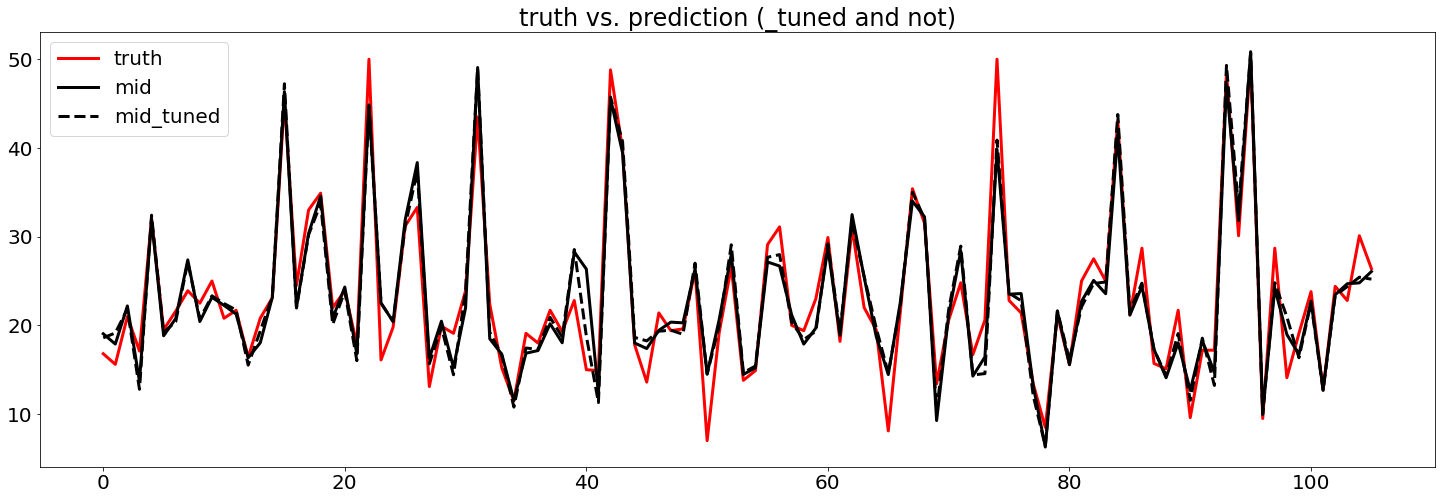

In [26]:
fig, ax = plt.subplots()

plt.title("truth vs. prediction (_tuned and not)")
dummy = range(len(predictions["mid"].values))
ax.plot(dummy, predictions["truth"].values, "-r", lw = 3, label = "truth")
ax.plot(dummy, predictions["mid"].values, "-k", lw = 3, label = "mid")
ax.plot(dummy, predictions["mid_tuned"].values, "--k", lw = 3, label = "mid_tuned")

plt.legend()
plt.show()

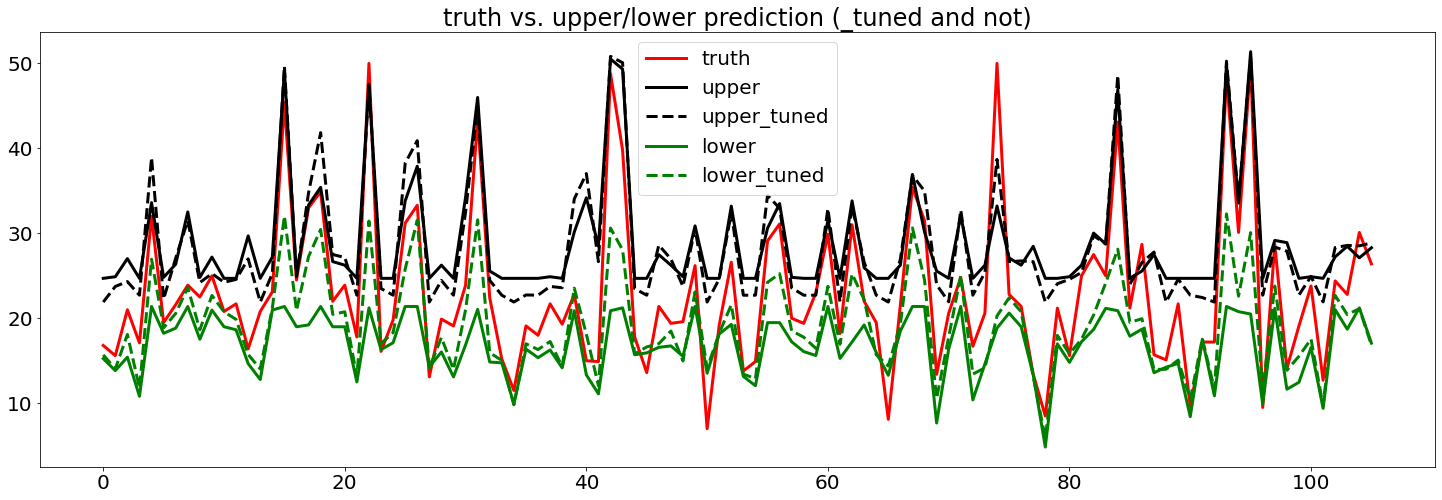

In [27]:
fig, ax = plt.subplots()

plt.title("truth vs. upper/lower prediction (_tuned and not)")
dummy = range(len(predictions["mid"].values))
ax.plot(dummy, predictions["truth"].values, "-r", lw=3, label="truth")
ax.plot(dummy, predictions["upper"].values, "-k", lw=3, label="upper")
ax.plot(dummy, predictions["upper_tuned"].values,
        "--k", lw=3, label="upper_tuned")

ax.plot(dummy, predictions["lower"].values, "-g", lw=3, label="lower")
ax.plot(dummy, predictions["lower_tuned"].values,
        "--g", lw=3, label="lower_tuned")

plt.legend()
plt.show()

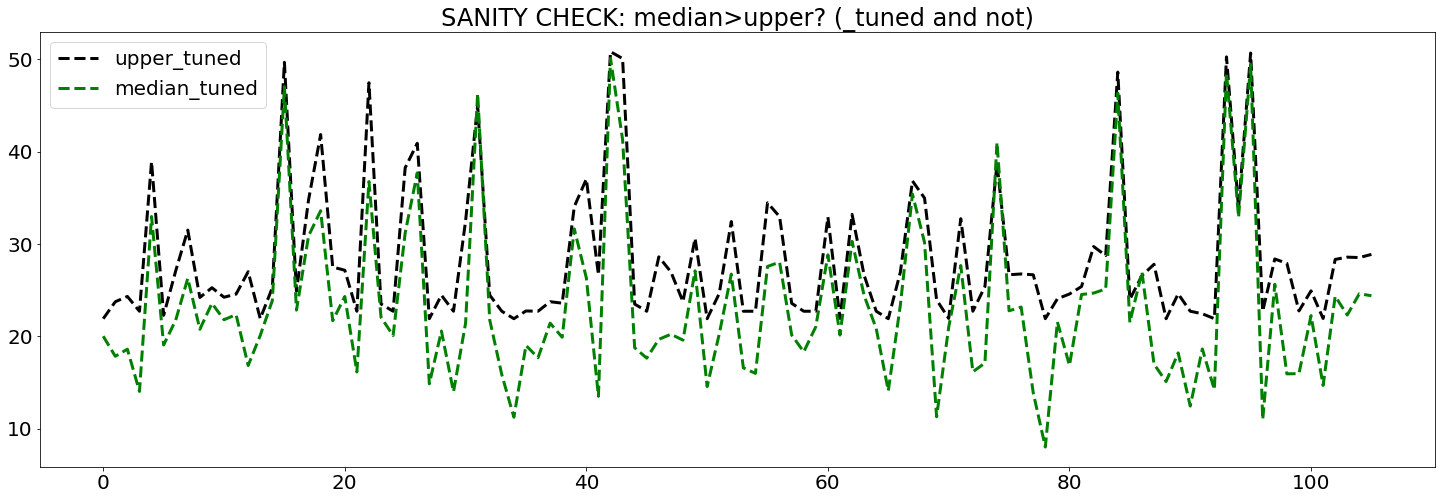

In [28]:
fig, ax = plt.subplots()

plt.title("SANITY CHECK: median>upper? (_tuned and not)")
#dummy = range(len(predictions["mid"].values))
#ax.plot(dummy, predictions["truth"].values, "-r", lw = 3, label = "truth")
#ax.plot(dummy, predictions["upper"].values, "-k", lw = 3, label = "upper")
ax.plot(dummy, predictions["upper_tuned"].values,
        "--k", lw=3, label="upper_tuned")

#ax.plot(dummy, predictions["median"].values, "-g", lw = 3, label = "median")
ax.plot(dummy, predictions["median_tuned"].values,
        "--g", lw=3, label="median_tuned")

plt.legend()
plt.show()

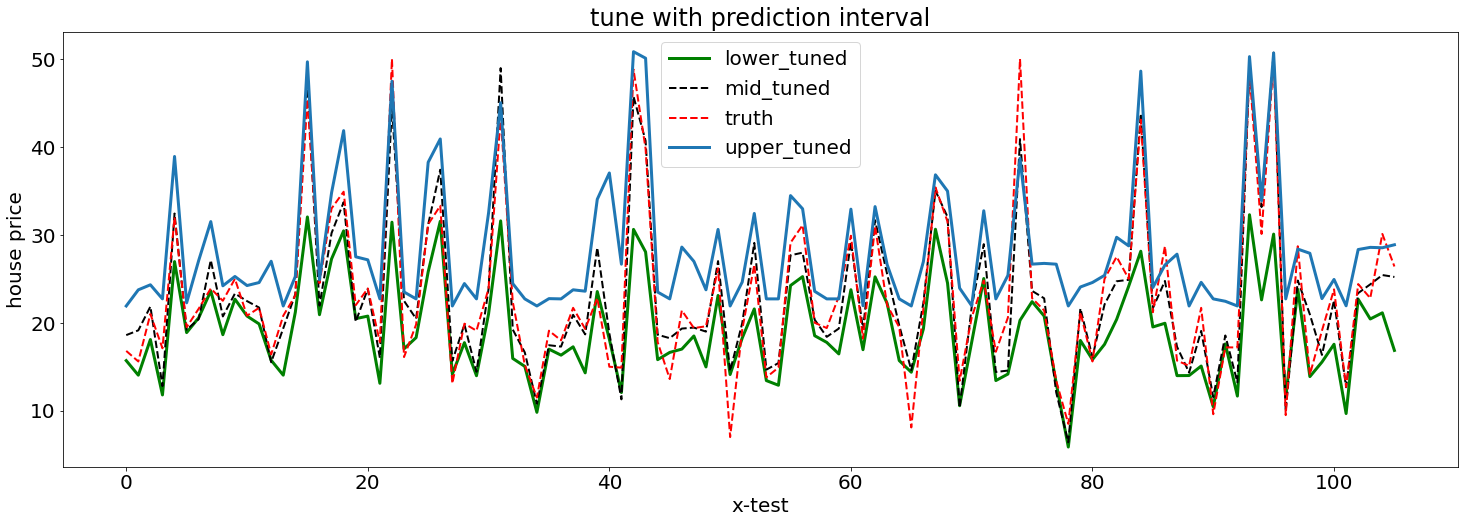

In [29]:
fig, ax = plt.subplots()

plt.title("tune with prediction interval")
ax.plot(dummy, predictions["lower_tuned"].values,
        "-g", lw=3, label="lower_tuned")
ax.plot(dummy, predictions["mid_tuned"].values, "--k", lw=2, label="mid_tuned")
ax.plot(dummy, predictions["truth"].values, "--r", lw=2, label="truth")
ax.plot(dummy, predictions["upper_tuned"].values,
        "-", lw=3, label="upper_tuned")

ax.set_xlabel("x-test")
ax.set_ylabel("house price")
plt.legend()
plt.show()

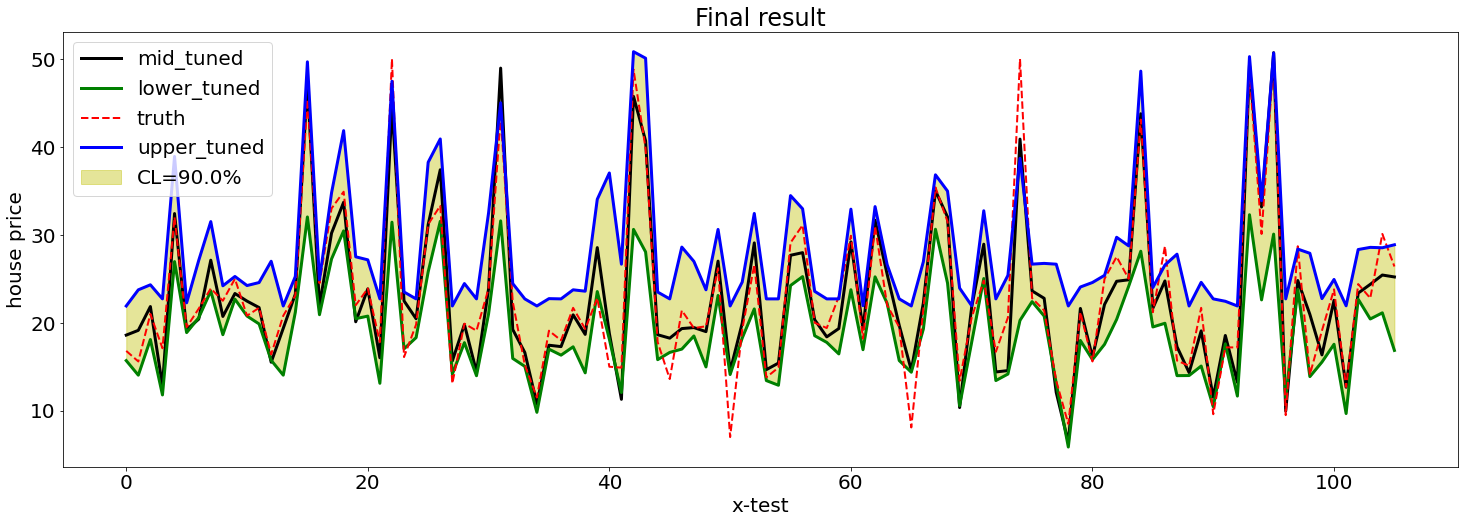

In [30]:
fig, ax = plt.subplots()

plt.title("Final result")
ax.plot(dummy, predictions["mid_tuned"].values, "-k", lw=3, label="mid_tuned")
ax.plot(dummy, predictions["lower_tuned"].values,
        "-g", lw=3, label="lower_tuned")
ax.plot(dummy, predictions["truth"].values, "--r", lw=2, label="truth")
ax.plot(dummy, predictions["upper_tuned"].values,
        "b-", lw=3, label="upper_tuned")

plt.fill_between(dummy, predictions["lower_tuned"].values, predictions["upper_tuned"].values, color="y", alpha=0.4,
                 label='CL=' + str(CL*100)+"%")

ax.set_xlabel("x-test")
ax.set_ylabel("house price")
plt.legend()
plt.show()

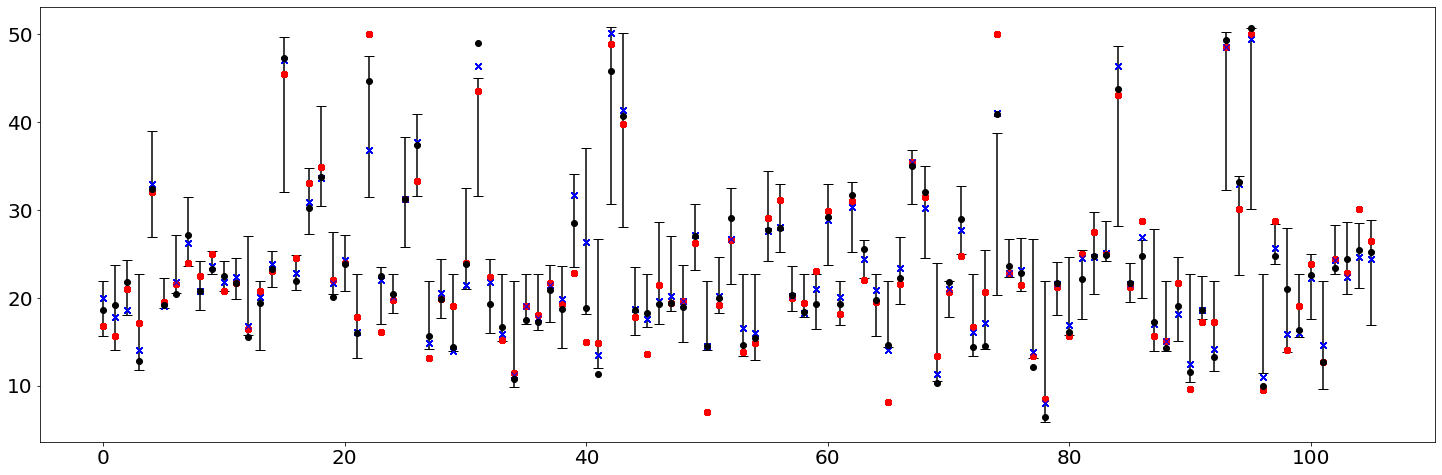

In [31]:
fig, ax = plt.subplots()

for i in range(len(predictions["ID"])):
    ax.plot(predictions["ID"], predictions["truth"], "ro")
    ax.plot(predictions["ID"], predictions["median_tuned"], "bx")
    mean = predictions["mid_tuned"][i]
    lower = mean - predictions["lower_tuned"][i]
    upper = predictions["upper_tuned"][i] - mean
    ax.errorbar(predictions["ID"][i], [mean], yerr=np.array([[lower, upper]]).T, fmt='ko-',
                solid_capstyle='projecting', capsize=5)

    # ax.legend()
plt.show()

# PI coverage probability (PICP) & MPIW (Mean PI width)


- [More important] **PI coverage probability (PICP)** is measured by counting the number of target values covered by the constructed PIs, where where ntest is the number of samples in the test set 
- [Less important] PICP has a direct relationship with the width of PIs. A satisfactorily large PICP can be easily achieved by widening PIs from either side. However, such PIs are too conservative and less useful in practice, as they do not show the variation of the targets. Therefore, a measure is required to check how wide the PIs are. **Mean PI width (MPIW)** quantifies this aspect. 
- The quality of PIs in this paper is assessed using the CWC.
- As  CWC  covers  both  key  featuresof  PIs  (width  and  coverage  probability),  it  can  be  used  as the objective function to be minimised.
- This means the **lower CWC is the better???**
- Reference about CWC: Khosravi, Abbas, et al. "Comprehensive review of neural network-based prediction intervals and new advances." IEEE Transactions on neural networks 22.9 (2011): 1341-1356.
- PIs  are  constructed  with  an  associated  90%  confidence level  (α equal  to  0.1). 
- η and μ are  set  to  50  and  0.9.



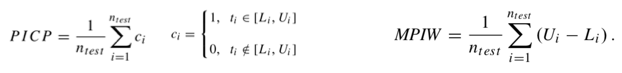

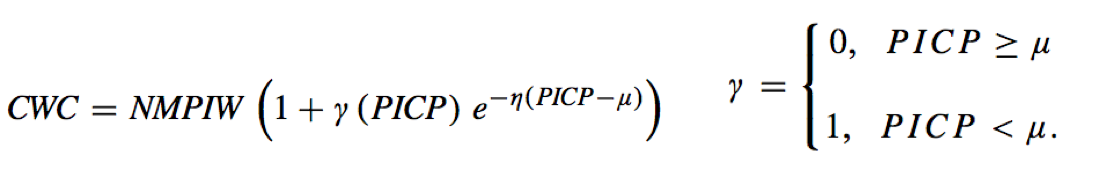

In [32]:
print("PICP      : ", len(
    predictions[predictions['inOrOut'] == True]) / len(X_test) * 100)
print("MPIW      : ", np.sum(predictions['width'].values) / len(X_test))

print("PICP_tuned: ", len(
    predictions[predictions['inOrOut_tuned'] == True]) / len(X_test) * 100)
print("MPIW_tuned: ", np.sum(predictions['width_tuned'].values) / len(X_test))

PICP      :  94.33962264150944
MPIW      :  12.045129688912905
PICP_tuned:  90.56603773584906
MPIW_tuned:  9.14606452156151


In [33]:
nu = 0.9
eta = 50
gamma = 0
PICP = len(predictions[predictions['inOrOut'] == True]) / len(X_test)
MPIW = np.sum(predictions['width'].values) / len(X_test)
delta = predictions['width'].max() - predictions['width'].min()
NMPIW = np.sum(predictions['width'].values) / len(X_test) / delta

if PICP < nu:
    gamma = 1

CWC = NMPIW * (1 + gamma * PICP * e**(- eta * (PICP - nu)))
print("CWC_notTuned=", CWC)

CWC_notTuned= 0.47840137724496284


In [34]:
nu = CL
gamma = 0
PICP = len(predictions[predictions['inOrOut_tuned'] == True]) / len(X_test)
MPIW = np.sum(predictions['width_tuned'].values) / len(X_test)
delta = predictions['width_tuned'].max() - predictions['width'].min()
NMPIW = np.sum(predictions['width_tuned'].values) / len(X_test) / delta

if PICP < nu:
    gamma = 1

CWC = NMPIW * (1 + gamma * e**(- eta * (PICP - nu)))
print("CWC_tuned=", CWC)

CWC_tuned= 0.5601845111995919


# Conclusion


- The Boston dataset is challenging because it has very little data ~500 pts.
- There are 3 models to tune: mean, upper and lowe qunatiles.
- The mean model is nothing more than the one you obtain normally.
- Each of the 3 model needs to be tuned separately and this is almost certainly going to kill oof any application for very big DL models.
- PICP & MIPW are two PI metrics for which you have to find a tradeoff.



# References


- https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed<br>
- https://nbviewer.jupyter.org/github/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb<br>
- https://scikit-learn.org/dev/auto_examples/ensemble/plot_gradient_boosting_quantile.html<br>

